# <center>Fashion-MNIST - Multiclass Classification with a CNN using Keras</center>
<!-- <center><img src="https://drive.google.com/uc?id=1zKjMLp3973vHUH9-K9mzfRhoRW3f7EpA"></center> -->
<center><img src="https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png"></center>

In this notebook, we will illustrate multi-class classification for the **Fashion-MNIST dataset** using a Keras based Convolution Neural Networks (CNN). We will develop a base model, which is progressively improved using L2 regularization as well as dropout regularization.  **We will be using Tensorflow's implementation of Keras in this workbook (i.e. all Keras classes are impored from `tensorflow.keras.*` packages)**

### <font color='firebrick'>NOTE: This notebook can work on Google Colab as well as offline</font>
* When running this notebook on Google Colab, please set `USE_COLAB=True` in cell below,  else set `USE_COLAB=False`.
* `USE_COLAB=True` will setup access to Google Drive for the current user's login (assuming she has a Google ID). 
    * Your Google Drive gets mapped to `/content/drive/My Drive`, and your Notebooks get saved to `/content/drive/My Drive/Colab Notebooks/` folder in your Google Drive. 
    * Code will add `/content/drive/My Drive/Colab Notebooks/` folder to `system.path`. Save your custom Python code files `(*.py)` here, so they are automatically added to `system.path` and you can use them in your notebook. * 
* A `MODEL_STATES` global var is created to point to the _correct_ folder where the model's state (i.e. trained weights & biases) is stored to an `.h5` file.
    * If `USE_COLAB=True`, `MODEL_STATES` maps to `/content/drive/My Drive/Colab Notebooks/model_states` folder on Google Drive.
    * Else, `MODEL_STATES` maps to `./model_states` folder on your local disk (i.e a sub-folder of folder where notebook is saved)

In [0]:
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    colab_notebooks_path = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(colab_notebooks_path):
        print('You Colab notebooks are available at ', colab_notebooks_path)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(colab_notebooks_path)
        print('NOTE: {} is appended to sys.path!'.format(colab_notebooks_path))
        # and test it
        import kr_helper_funcs as kru
        MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/
NOTE: /content/drive/My Drive/Colab Notebooks/ is appended to sys.path!


## About the Fashion-MNIST dataset. 
Fashion-MNIST can be used as drop-in replacement for the original MNIST dataset (of 10 categories of handwritten digits). It shares the same image size (28x28 graysacle) and has 60,000 training and 10,000 testing splits. However, unlike the 'simple' number images, the images from this dataset are a bit involved. So, our CNN network architecture will be different.

Per [Zolando](https://github.com/zalandoresearch/fashion-mnist), the Fashion-MNIST dataset was created as a replacement for the MNIST dataset because:
* **MNIST is too easy**. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. 
* **MNIST is overused**. 
* **MNIST cannot represent modern CV tasks**
Take a look at the link above and read the various articles it references.

We have 10 categories of output labels - unlike the MNIST dataset, where they were values for numbers, we have distinct types here.

Label Description 
* 0 - T-shirt/top 
* 1 - Trouser 
* 2 - Pullover 
* 3 - Dress 
* 4 - Coat 
* 5 - Sandal 
* 6 - Shirt 
* 7 - Sneaker 
* 8 - Bag 
* 9 - Ankle boot

Let's begin...

In [0]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
%matplotlib inline

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn")

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

import warnings
warnings.filterwarnings('ignore')

Using Tensorflow version  1.14.0


### Loading & Preprocessing the Dataset

I am going to load the Fashion-MNIST dataset from the `keras.datasets` library. We'll use the `keras.datasets.fashion_mnist.load_data()` call. The dataset is downloaded the very first time you call it. The function conveniently returns two tuples of data & labels. The images are not normalized - this is something we will handle.

In [0]:
def load_and_preprocess_data(debug=False):
    
    from tensorflow.keras.datasets.fashion_mnist import load_data
    #from keras.utils import to_categorical

    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

    # per Andrew Ng's advise in his Structured ML coure (on deeplearning.ai), the test 
    # & cross-validation datasets must come from the same distribution!
    # So, we are going to split X_test/y_test into cross-validation & test datasets.
    # We have 10,000 samples in X_test/y_test - we will assign 8,000 to X_val/y_val & the
    # remaining 2,000 to X_test/y_test (test dataset) AFTER randomly sorting the dataset

    # randomly sort X_test/y_test
    indexes = np.arange(X_test.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    
    # 'split' into cross-val & test sets (use 6000 records in cross-val set)    
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()

    # scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [0]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [0]:
# load & pre-process our dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)

4423680/4422102 [==============================] - 0s 0us/step
Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000,)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000,)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000,)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


Notice the following:
* **Before Pre-processing**:
    * We have 60,000 images in the training set & 10,000 images in the test set. 
    * They have shapes of `(60000,28,28)` and `(10000,28,28)` respectively. 
* **After pre-processing**: 
    * The training dataset retains it's 60000 images 
    * The test dataset has been split into a cross-validation set (X_val/y_val) with 8000 samples and a test set (X_test/y_test) with 2000 samples
    * We have reshaped all the feature (X's) datasets into 3D tensors

Let us randomly select 50 images from the test dataset and see how they look - we will display the images in a 5x10 grid below.

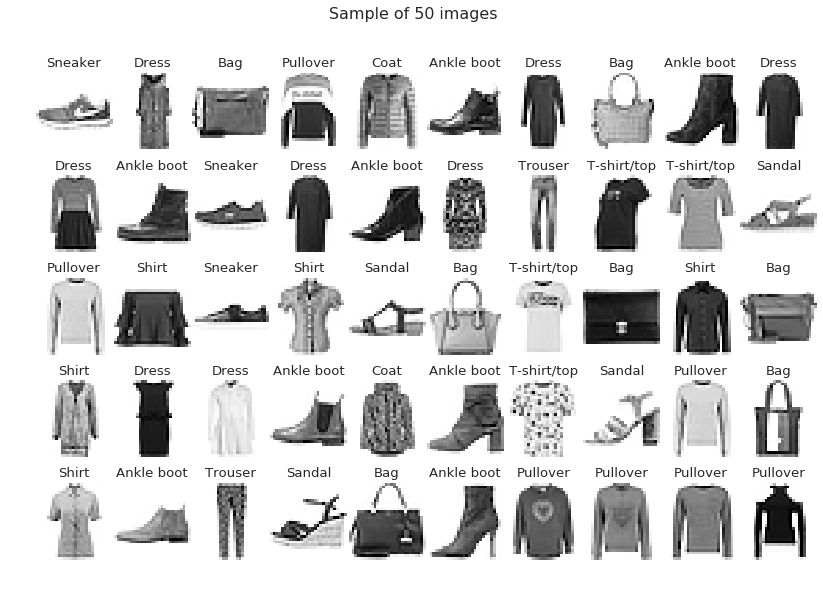

In [0]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, plot_title='Sample of %d images' % sample_size)

## Keras Model Development

This section includes the following functions:
* `train_and_evaluate_model()` - trains model on training dataset & evaluates performance on the cross-validation dataset. Saves model to a file name on disk (Google Drive if running in Colab or directory on disk)
* `do_predictions()` - loads model state from disk and tests it on test dataset and plots predictions on a random sample of non-preprocessed data from the test set.

In [0]:
# Keras imports (from Tensorflow)
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import kr_helper_funcs as kru
print('Using Tensorflow\'s implementation of Keras version ', tf.keras.__version__)

K.clear_session()   # start afresh each time!!

Using Tensorflow's implementation of Keras version  2.2.4-tf


In [0]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

In [0]:
# cross-train & evaluate model's performance
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                             num_epochs=25, batch_size=32, plot_title=None, 
                             callbacks=None, model_save_name=None):
    """
    cross train & evaluate model's performance on training, cross-val & test datasets
    @params:
        - X_train/y_train: pre-processed training datasets
        - X_val/y_val: pre-processed cross-validation datasets
        - X_test/y_test: pre-processed testing datasets
        - epochs (optional, default=25) - no of epochs for which training should be done
        - batch_size (optional, default=32) - the batch size to use for mini-batch gradient descent training
        - plot_title (optional, default=None) - plots loss vs epochs and accuracy vs epoch curves if assigned value
            other than None. Uses this assigned value as the plot's title
        - model_save_name (optional, default=None) - the file name to which the Keras model is to be saved to.
    """
    
    # train on X_train/y_train & cross-validate on X_val/y_val
    history = model.fit(X_train, y_train, epochs=num_epochs,
        batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    
    kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
    print('Test data:', flush=True)
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print("  Testing  : loss %.3f - acc %.3f" % (loss, acc))
    
    if model_save_name is not None:
        print('Saving model...', flush=True)
        kru.save_keras_model(model, model_save_name, MODEL_SAVE_DIR)

In [0]:
def do_predictions(model_save_name, X_test, y_test, test_images, test_labels, 
                   plot_title=None, use_tf_keras_impl=False):
    
    def test_model(model, X_test, y_test, test_images, test_labels, plot_title=None):
        print('Evaluating against test data...', flush=True)
        loss, acc = model.evaluate(X_test, y_test)
        print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

        print('Displaying sample predictions...', flush=True)
        # run predictions
        y_pred = model.predict(X_test)

        # test with 50 random images
        num_images = 50
        rand_indexes = np.random.randint(0, len(X_test), num_images)
        sample_images = test_images[rand_indexes]
        sample_labels = test_labels[rand_indexes]
        sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

        display_sample(sample_images, sample_labels, sample_predictions,
            num_rows=5, num_cols=10, plot_title=plot_title)
    
    # load the model from saved state (.hd5 archive)
    model = kru.load_keras_model(model_save_name, MODEL_SAVE_DIR)
    
    test_model(model, X_test, y_test, test_images, test_labels, plot_title=plot_title)
    del model

## Training Model
In this section, we _cross-train_ various configurations of the model on `(X_train, y_train)` and `(X_val, y_val)` and record the performance. The model we will use is created in the `build_model()` function below. The following _configurations_ are trained and evaluated:
>Configuration|
>:---|
>**Base Model** (no regularization)| 
>**Base Model + L2 Regularization**|
>**Base Model + Dropout Regularization**|
>**Base Model + L2 Regularization + Dropout Regularization**|

You can see how the model's performance improves as overfitting reduces.

### Training the _base_ model
Training model without any regularization - no Batch Normalization, no L2 regularization and no Dropout regularization

In [0]:
def build_model():
    """
    builds the base Keras model, without any regularization
    """
    K.clear_session()
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        
        Dense(512, activation='relu'),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
# build the base Keras model - no L2 regularization, no droput regularization
model = build_model()
print(model.summary())

W0713 02:47:42.613787 139844475635584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       5

Train on 60000 samples, validate on 8000 samples
Epoch 1/20
60000/60000 [==============================] - 40s 668us/sample - loss: 0.3996 - acc: 0.8561 - val_loss: 0.3205 - val_acc: 0.8800
Epoch 2/20
60000/60000 [==============================] - 38s 639us/sample - loss: 0.2461 - acc: 0.9103 - val_loss: 0.3021 - val_acc: 0.8885
Epoch 3/20
60000/60000 [==============================] - 38s 637us/sample - loss: 0.1918 - acc: 0.9278 - val_loss: 0.2939 - val_acc: 0.8951
Epoch 4/20
60000/60000 [==============================] - 38s 634us/sample - loss: 0.1513 - acc: 0.9443 - val_loss: 0.2606 - val_acc: 0.9114
Epoch 5/20
60000/60000 [==============================] - 38s 638us/sample - loss: 0.1174 - acc: 0.9563 - val_loss: 0.3059 - val_acc: 0.9018
Epoch 6/20
60000/60000 [==============================] - 38s 639us/sample - loss: 0.0932 - acc: 0.9646 - val_loss: 0.2978 - val_acc: 0.9096
Epoch 7/20
60000/60000 [==============================] - 38s 632us/sample - loss: 0.0761 - acc: 0.9712 -

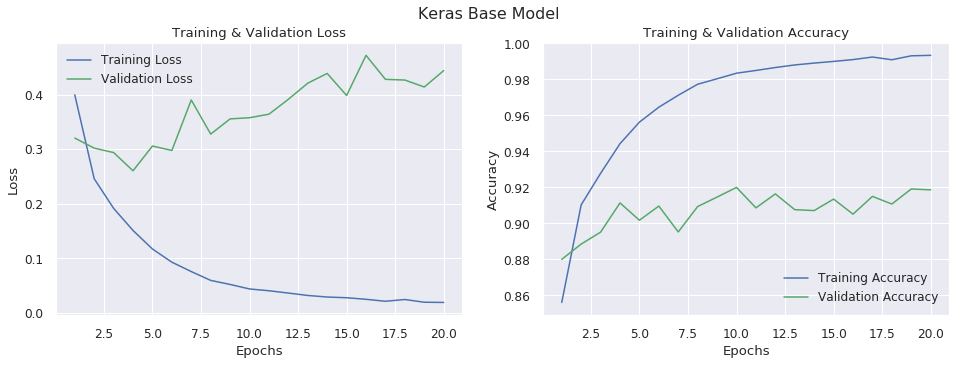


Evaluating...
Training data:
60000/60000 [==============================] - 14s 241us/sample - loss: 0.0211 - acc: 0.9930
  Training : loss 0.021 - acc 0.993
Cross-validation data:
8000/8000 [==============================] - 2s 239us/sample - loss: 0.4440 - acc: 0.9186
  Cross-val: loss 0.444 - acc 0.919
Test data:
2000/2000 [==============================] - 1s 261us/sample - loss: 0.4842 - acc: 0.9080
  Testing  : loss 0.484 - acc 0.908
Saving model...
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5


In [0]:
model_name_base = 'kr_fashion_cnn_base'
plot_title_base = 'Keras Base Model'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                         num_epochs=20, batch_size=64, 
                         plot_title=plot_title_base, model_save_name=model_name_base) 
#del model

In [0]:
kru.save_keras_model(model, model_name_base, MODEL_SAVE_DIR)
del model

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5


#### Observation from training base model:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|91-92%|90-91%

* Model is overfitting the training data - observe the large (~8%) difference between training & cross-validation accuracies
* Cross-validation & test accuracies should be almost equal as data is drawn from same population - they are!
* From the plots you can see that they curves start diverging from around the 5th epoch, suggesting that the model has started overfitting from this epoch itself. You could have stopped training after 5 epochs and got the best results (~95% training accuracy and 90% cross-val accuracy)

Let's run some predictions against the `test` dataset, which the model has not _seen_ during training.
* I expect to see the same `Test acc` value as seen in the output from training the model

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 379us/sample - loss: 0.4842 - acc: 0.9080
  - Test data: loss 0.484 - acc 0.908
Displaying sample predictions...


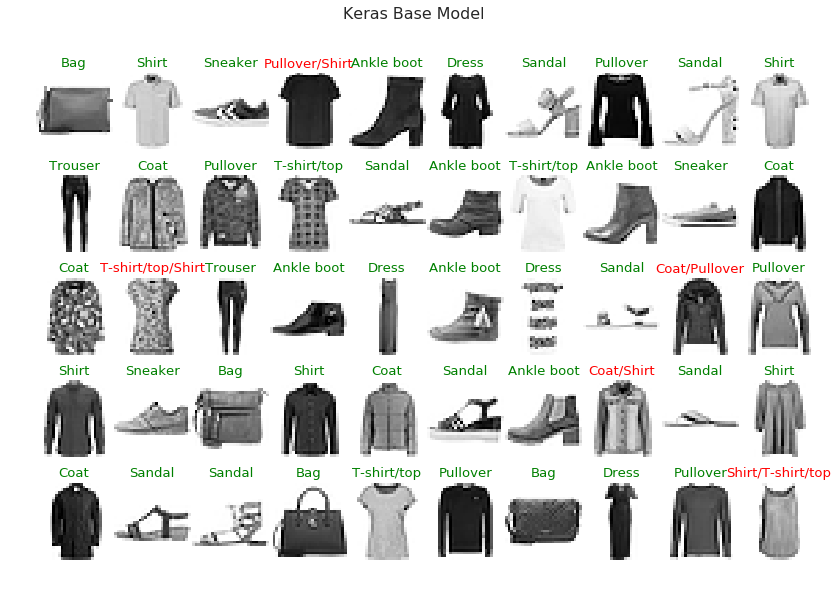

In [0]:
do_predictions(model_name_base, X_test, y_test, test_images, test_labels, 
               plot_title=plot_title_base, use_tf_keras_impl=True)

### Using L2 Regularization with Base Model
In this section we will add L2 Regularization to the base model. 
* A L2 regularizer applies penalties on layer parameters (equal to the `L2 Norm` of weights) during optimization. 
* These penalties are _added to the loss function_ that the network _minimizes_. Thus higher weights/parameters tend to get penalized more, so we eventually end up with simpler models that overfit less.
* L2 Regularization can be added to any Keras `Conv2D` or `Dense` layer by setting the `kernel_regularizer` parameter to an appropriate value. We use `kernel_regularizer = regularizers.l2(XXXX)`. 
* L2 regularization is applied if you set `use_l2_reg=True` in the `build_model()` function. The penalty applied can be changed by passing your value in the `l2_loss_lambda` parameter of `build_model()` function.
* In an ideal situation, applying L2 regularization should reduce the gap between `training accuracy` and `cross-val accuracy`, without reducing `cross-cal accuracy` (it could increase!). 

In [0]:
def build_model_l2(l2_loss_lambda):
    """
    Builds Keras model with L2 regularization applied to each Conv2D and Dense layers
    @params:
        - l2_loss_lambda: float, controls amount of regularization to apply
             (optional, default=None)
    """
    K.clear_session()
    
    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)    
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2, 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu', kernel_regularizer=l2),
        
        Dense(512, activation='relu', kernel_regularizer=l2),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
l2_loss_lambda = 0.010
model = build_model_l2(l2_loss_lambda=l2_loss_lambda)
print(model.summary())

Using L2 regularization - l2_loss_lambda = 0.0100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_

Train on 60000 samples, validate on 8000 samples
Epoch 1/30
60000/60000 [==============================] - 40s 668us/sample - loss: 10.4855 - acc: 0.8536 - val_loss: 5.5332 - val_acc: 0.8774
Epoch 2/30
60000/60000 [==============================] - 39s 650us/sample - loss: 3.5761 - acc: 0.9058 - val_loss: 2.3814 - val_acc: 0.8914
Epoch 3/30
60000/60000 [==============================] - 39s 649us/sample - loss: 1.7250 - acc: 0.9185 - val_loss: 1.3403 - val_acc: 0.9084
Epoch 4/30
60000/60000 [==============================] - 39s 650us/sample - loss: 1.0794 - acc: 0.9268 - val_loss: 0.9643 - val_acc: 0.9069
Epoch 5/30
60000/60000 [==============================] - 39s 651us/sample - loss: 0.7947 - acc: 0.9323 - val_loss: 0.7750 - val_acc: 0.9099
Epoch 6/30
60000/60000 [==============================] - 39s 650us/sample - loss: 0.6428 - acc: 0.9395 - val_loss: 0.6884 - val_acc: 0.9020
Epoch 7/30
60000/60000 [==============================] - 39s 650us/sample - loss: 0.5533 - acc: 0.9432 

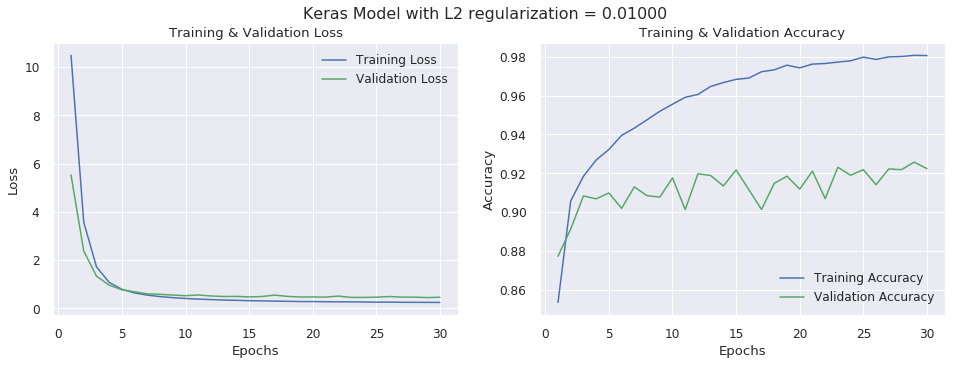


Evaluating...
Training data:
60000/60000 [==============================] - 15s 250us/sample - loss: 0.2409 - acc: 0.9853
  Training : loss 0.241 - acc 0.985
Cross-validation data:
8000/8000 [==============================] - 2s 249us/sample - loss: 0.4645 - acc: 0.9224
  Cross-val: loss 0.465 - acc 0.922
Test data:
2000/2000 [==============================] - 0s 244us/sample - loss: 0.4497 - acc: 0.9280
  Testing  : loss 0.450 - acc 0.928
Saving model...
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2.h5


In [0]:
model_name_l2 = 'kr_fashion_cnn_l2'
plot_title_l2 = 'Keras Model with L2 regularization = %.5f' % l2_loss_lambda
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                         num_epochs=30, batch_size=64, 
                         plot_title=plot_title_l2, model_save_name=model_name_l2)
#del model

In [0]:
kru.save_keras_model(model, model_name_l2, MODEL_SAVE_DIR)
del model

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_0.00250.h5


#### Observations - model with L2 Regularization:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|91-92%|90-91%
>**L2 Regularization**|98-99%|92-93%|92-93%

* Overfitting has reduced - difference between train & cross-val accuracies is just ~5% (as compared to 9% in the base model)
* Cross-validation & test accuracies should be almost equal as data is drawn from same population - they are! 
* Also a critical success factor was that these should not be much lesser than the base model's - they have in fact improved!
* The plots are also much better - notice that the curves are following each other more closely than before - though they are digressing slightly.

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 384us/sample - loss: 0.4497 - acc: 0.9280
  - Test data: loss 0.450 - acc 0.928
Displaying sample predictions...


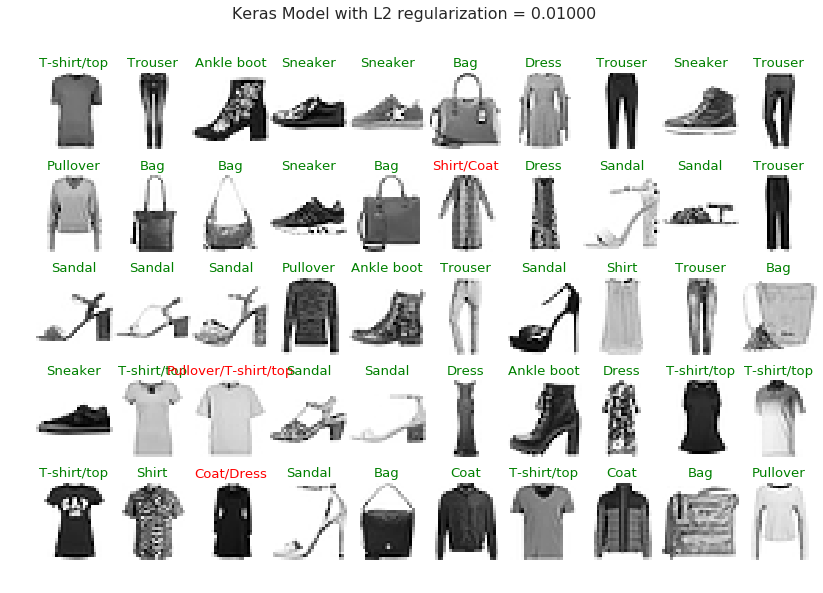

In [0]:
do_predictions(model_name_l2, X_test, y_test, test_images, test_labels, 
               plot_title=plot_title_l2)

### Training the model with Dropout Regularization
Another very effective regularization technique is **Dropout Regularization**. It works by randomly _dropping_ nodes in a layer _during training_ (you specify the percentage of nodes to be dropped). This give the model an 'impression' that a different network is being trained during each epoch, thereby achieving a regularization effect.

In [0]:
def build_model_do():
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.20),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.30),        
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.40),        
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        Dropout(0.30),
        
        Dense(512, activation='relu'),
        Dropout(0.20),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
model = build_model_do()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)      

Train on 60000 samples, validate on 8000 samples
Epoch 1/30
60000/60000 [==============================] - 41s 687us/sample - loss: 0.7254 - acc: 0.7340 - val_loss: 0.4631 - val_acc: 0.8305
Epoch 2/30
60000/60000 [==============================] - 40s 669us/sample - loss: 0.4241 - acc: 0.8449 - val_loss: 0.3387 - val_acc: 0.8799
Epoch 3/30
60000/60000 [==============================] - 40s 670us/sample - loss: 0.3489 - acc: 0.8722 - val_loss: 0.2936 - val_acc: 0.8915
Epoch 4/30
60000/60000 [==============================] - 40s 671us/sample - loss: 0.3044 - acc: 0.8902 - val_loss: 0.3312 - val_acc: 0.8783
Epoch 5/30
60000/60000 [==============================] - 40s 669us/sample - loss: 0.2773 - acc: 0.8995 - val_loss: 0.2694 - val_acc: 0.8996
Epoch 6/30
60000/60000 [==============================] - 40s 670us/sample - loss: 0.2575 - acc: 0.9060 - val_loss: 0.2407 - val_acc: 0.9151
Epoch 7/30
60000/60000 [==============================] - 40s 671us/sample - loss: 0.2372 - acc: 0.9133 -

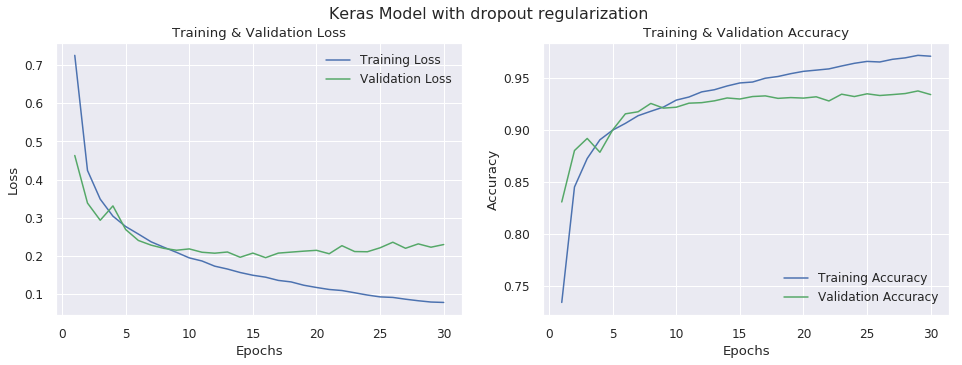


Evaluating...
Training data:
60000/60000 [==============================] - 14s 241us/sample - loss: 0.0316 - acc: 0.9897
  Training : loss 0.032 - acc 0.990
Cross-validation data:
8000/8000 [==============================] - 2s 244us/sample - loss: 0.2301 - acc: 0.9336
  Cross-val: loss 0.230 - acc 0.934
Test data:
2000/2000 [==============================] - 0s 240us/sample - loss: 0.2165 - acc: 0.9405
  Testing  : loss 0.217 - acc 0.941
Saving model...
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do.h5


In [0]:
model_name_do = 'kr_fashion_cnn_do'
plot_title_do = 'Keras Model with dropout regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                         num_epochs=30, batch_size=64, 
                         plot_title=plot_title_do, model_save_name=model_name_do)

In [0]:
kru.save_keras_model(model, model_name_do, MODEL_SAVE_DIR)
del model

#### Observation - model with dropout regularization:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|91-92%|90-91%
>**L2 Regularization**|98-99%|92-93%|92-93%
>**Dropout Reg**|99-100%|93-94%|93-94%

* Dropput regularization appears to be working better for this model - overfitting has reduced further, by another 1%. 
* Cross-validation & test accuracies have also improved by 1% or so.
* The plots are diverging after 10 epochs.

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 211us/sample - loss: 0.2165 - acc: 0.9405
  - Test data: loss 0.217 - acc 0.941
Displaying sample predictions...


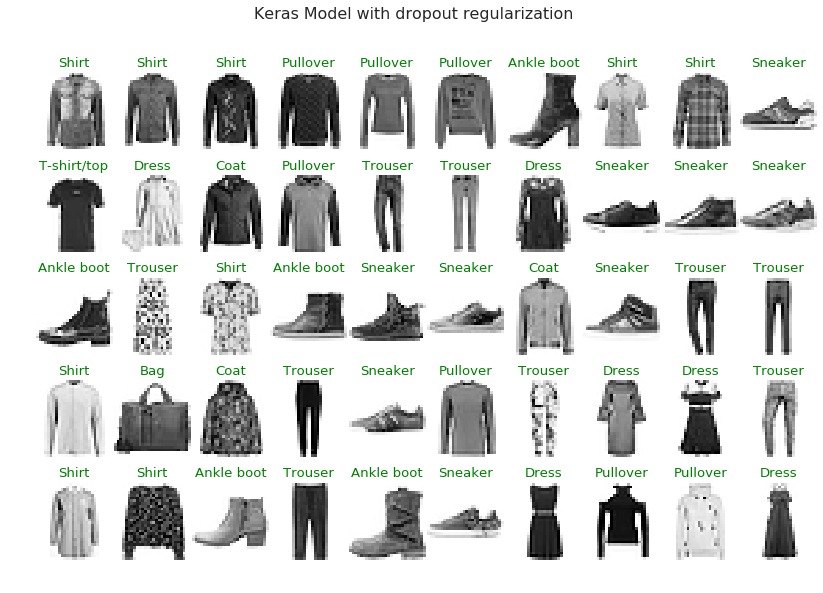

In [0]:
do_predictions(model_name_do, X_test, y_test, test_images, test_labels, plot_title=plot_title_do)

### Using Both L2 regularization and Dropout Regularization
Let's try adding both L2 regularization as well as dropout regularization. We observed that we are getting rather good test accuracy with dropout regularization. So, I'll be applying just a _slight amount_ of L2 regularization. We'll use a very small value for `l2_loss_lambda`.

In [0]:
def build_model_l2_do(l2_loss_lambda=None):
    
    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.7f' % l2_loss_lambda)
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2,
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.20),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.30),        
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.40),        
        
        Flatten(),
        
        Dense(1024, activation='relu', kernel_regularizer=l2),
        Dropout(0.30),
        
        Dense(512, activation='relu', kernel_regularizer=l2),
        Dropout(0.20),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
l2_loss_lambda_2 = 0.00020
model = build_model_l2_do(l2_loss_lambda=l2_loss_lambda_2)
print(model.summary())

Using L2 regularization - l2_loss_lambda = 0.0002000
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_43 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
c

Train on 60000 samples, validate on 8000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 335us/sample - loss: 1.0783 - acc: 0.7385 - val_loss: 0.7500 - val_acc: 0.8522
Epoch 2/50
60000/60000 [==============================] - 18s 298us/sample - loss: 0.7621 - acc: 0.8511 - val_loss: 0.6657 - val_acc: 0.8820
Epoch 3/50
60000/60000 [==============================] - 18s 298us/sample - loss: 0.6790 - acc: 0.8767 - val_loss: 0.6330 - val_acc: 0.8904
Epoch 4/50
60000/60000 [==============================] - 18s 298us/sample - loss: 0.6257 - acc: 0.8922 - val_loss: 0.6019 - val_acc: 0.8975
Epoch 5/50
60000/60000 [==============================] - 18s 297us/sample - loss: 0.5881 - acc: 0.9015 - val_loss: 0.5712 - val_acc: 0.9047
Epoch 6/50
60000/60000 [==============================] - 18s 298us/sample - loss: 0.5506 - acc: 0.9100 - val_loss: 0.5262 - val_acc: 0.9171
Epoch 7/50
60000/60000 [==============================] - 18s 298us/sample - loss: 0.5194 - acc: 0.9166 -

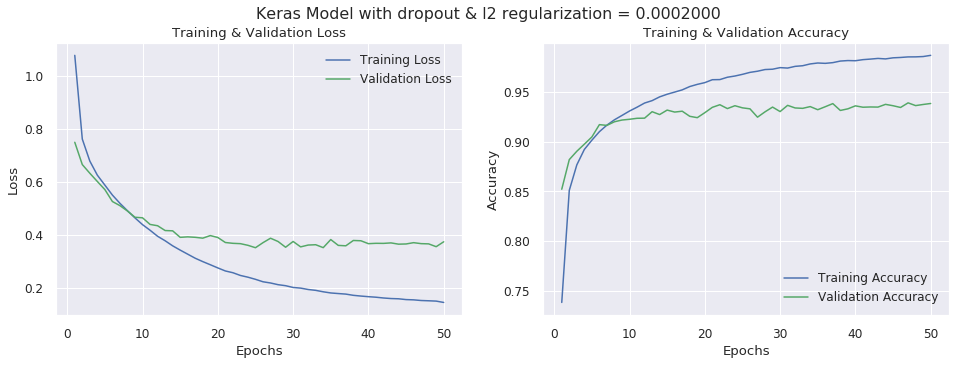


Evaluating...
Training data:
60000/60000 [==============================] - 8s 139us/sample - loss: 0.1136 - acc: 0.9988
  Training : loss 0.114 - acc 0.999
Cross-validation data:
8000/8000 [==============================] - 1s 138us/sample - loss: 0.3742 - acc: 0.9384
  Cross-val: loss 0.374 - acc 0.938
Test data:
2000/2000 [==============================] - 0s 139us/sample - loss: 0.3576 - acc: 0.9415
  Testing  : loss 0.358 - acc 0.942
Saving model...
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_do.h5


In [0]:
# training for more epochs as we have greater regularization values...
model_name_do_l2 = 'kr_fashion_cnn_l2_do' 
plot_title_do_l2 = 'Keras Model with dropout & l2 regularization = %.7f' % l2_loss_lambda_2
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                         num_epochs=50, batch_size=64, 
                         plot_title=plot_title_do_l2, model_save_name=model_name_do_l2)

In [0]:
kru.save_keras_model(model, model_name_do_l2, MODEL_SAVE_DIR)
del model

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_do.h5


#### Observation - model with both L2 and Dropout regularization.
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|91-92%|90-91%
>**L2 Regularization**|98-99%|92-93%|92-93%
>**Dropout Reg**|99-100%|93-94%|93-94%
>**Both L2 & Dropout Reg**|99-100%|93-94%|94-95%

* This is slightly better than the model with just L2 or just dropout regularization - we are getting a slightly better test accuracy, with the overfitting beging in the same range as before.

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_do.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 397us/sample - loss: 0.3576 - acc: 0.9415
  - Test data: loss 0.358 - acc 0.942
Displaying sample predictions...


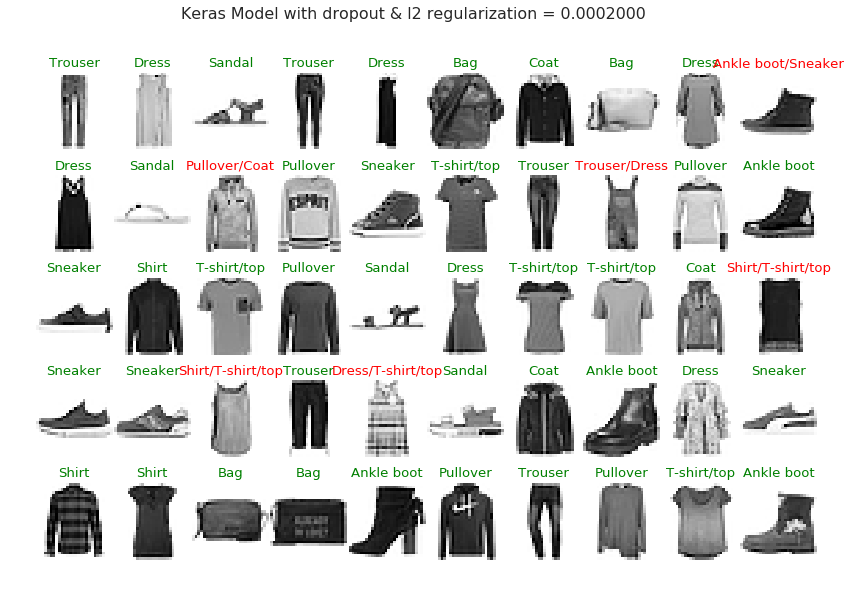

In [0]:
do_predictions(model_name_do_l2, X_test, y_test, test_images, test_labels, plot_title=plot_title_do_l2)

### Using Image Augmentation

One of the main reasons for model overfitting that we are trying to fit a complex model to limited training data. Keras comes to the rescue by providing `Image Augmentation` technique that let's us artifically increase the amount and variety of training data that we feed to the model. This way, the model learns more intricate patterns and is able to generalize better to data it has not seen. In this section we will implement Image Augmentation on the model that used both L2 as well as Dropout Regularization before.

In [0]:
def train_and_evaluate_model_aug(model, X_train, y_train, X_val, y_val, X_test, y_test,
                                 num_epochs=100, batch_size=32, plot_title=None, 
                                 callbacks=None, model_save_name=None):
    from keras.preprocessing.image import ImageDataGenerator

    # NOTE: our datasets have already been scaled 
    train_datagen = ImageDataGenerator( 
        rotation_range=10,        # randomly rotate between 0-rotation_range angle
        width_shift_range=0.2,    # randomly shift horizontally by this much
        height_shift_range=0.2,   # randomly shift vertically by this much
        shear_range=0.2,          # randomly shear by this much
        zoom_range=0.2,           # randomly zoom (80% - 120%)
        horizontal_flip=True,
        fill_mode='nearest'       # fill any pixels lost in xform with nearest
    )

    val_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    #train_datagen.fit(X_train)

    # fit the data generator on training data & validate on
    num_train_batches = len(X_train) // batch_size
    num_train_batches += (0 if len(X_train) % batch_size == 0 else 1)     
    num_val_batches = len(X_val) // batch_size
    num_val_batches += (0 if len(X_val) % batch_size == 0 else 1)     
    num_test_batches = len(X_test) // batch_size
    num_test_batches += (0 if len(X_test) % batch_size == 0 else 1)    
    
    train_generator = train_datagen.flow(X_train, y_train, 
                                         batch_size=batch_size,
                                         seed=123)
    val_generator = train_datagen.flow(X_val, y_val, 
                                         batch_size=batch_size,
                                         seed=123)
    test_generator = test_datagen.flow(X_test, y_test, 
                                       batch_size=batch_size,
                                       seed=123)

    history = model.fit_generator(train_generator,
                                  steps_per_epoch = num_train_batches, 
                                  epochs = num_epochs,
                                  validation_data = val_generator,
                                  validation_steps = num_val_batches)
    
    kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate_generator(train_generator, 
                                         steps=num_train_batches,
                                         verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate_generator(val_generator, 
                                         steps=num_val_batches,
                                         verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))    
    print('Test data:', flush=True)
    loss, acc = model.evaluate_generator(test_generator, 
                                         steps=num_test_batches,
                                         verbose=1)
    print("  Testing  : loss %.3f - acc %.3f" % (loss, acc))
    
    if model_save_name is not None:
        print('Saving model...', flush=True)
        kru.save_keras_model(model, model_save_name, MODEL_SAVE_DIR)

In [0]:
l2_loss_lambda_2 = 0.00020
model = build_model_l2_do(l2_loss_lambda=l2_loss_lambda_2)
print(model.summary())

Using L2 regularization - l2_loss_lambda = 0.0002000
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_54 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_55 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
c

Epoch 1/200
938/938 [==============================] - 30s 32ms/step - loss: 1.5182 - acc: 0.5743 - val_loss: 1.1075 - val_acc: 0.7117
Epoch 2/200
938/938 [==============================] - 24s 25ms/step - loss: 1.0922 - acc: 0.7236 - val_loss: 0.9508 - val_acc: 0.7735
Epoch 3/200
938/938 [==============================] - 24s 25ms/step - loss: 0.9751 - acc: 0.7646 - val_loss: 0.8732 - val_acc: 0.8014
Epoch 4/200
938/938 [==============================] - 24s 25ms/step - loss: 0.9021 - acc: 0.7912 - val_loss: 0.8531 - val_acc: 0.8099
Epoch 5/200
938/938 [==============================] - 24s 25ms/step - loss: 0.8380 - acc: 0.8106 - val_loss: 0.8080 - val_acc: 0.8173
Epoch 6/200
938/938 [==============================] - 24s 25ms/step - loss: 0.7973 - acc: 0.8231 - val_loss: 0.7524 - val_acc: 0.8342
Epoch 7/200
938/938 [==============================] - 24s 25ms/step - loss: 0.7560 - acc: 0.8347 - val_loss: 0.7220 - val_acc: 0.8401
Epoch 8/200
938/938 [==============================] - 

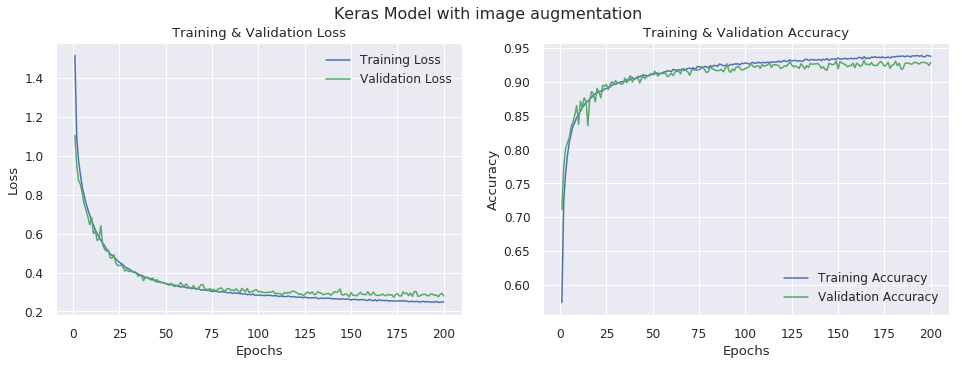


Evaluating...
Training data:
938/938 [==============================] - 17s 18ms/step - loss: 0.2044 - acc: 0.9535
  Training : loss 0.204 - acc 0.953
Cross-validation data:
125/125 [==============================] - 2s 18ms/step - loss: 0.2833 - acc: 0.9256
  Cross-val: loss 0.283 - acc 0.926
Test data:
32/32 [==============================] - 0s 9ms/step - loss: 0.2938 - acc: 0.9265
  Testing  : loss 0.294 - acc 0.927
Saving model...
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.h5


In [0]:
model_name_aug = 'kr_fashion_cnn_aug' 
plot_title_aug = 'Keras Model with image augmentation' 
train_and_evaluate_model_aug(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                             num_epochs=200, batch_size=64, 
                             plot_title=plot_title_aug, 
                             model_save_name=model_name_aug)

In [0]:
kru.save_keras_model(model, model_name_aug, MODEL_SAVE_DIR)
del model

#### Observation - model with Image Augmentation
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|91-92%|90-91%
>**L2 Regularization**|98-99%|92-93%|92-93%
>**Dropout Reg**|99-100%|93-94%|93-94%
>**Both L2 & Dropout Reg**|99-100%|93-94%|94-95%
>**With Image Aug**|95-96%|92-93%|92-93%

* Notice that the cross-validation plots are tracking the training plots (both loss and accuracy) - there is some divergence, but very little.
* We observe a 3% difference between training and cross-validation accuracy, which indicates that we have some overfitting, but not much.
* Extrapolating the loss and accuracy curves, it appears that they will diverge further if we train for more epochs. At the 100th epoch divergence is ~2%

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 392us/sample - loss: 0.2943 - acc: 0.9265
  - Test data: loss 0.294 - acc 0.927
Displaying sample predictions...


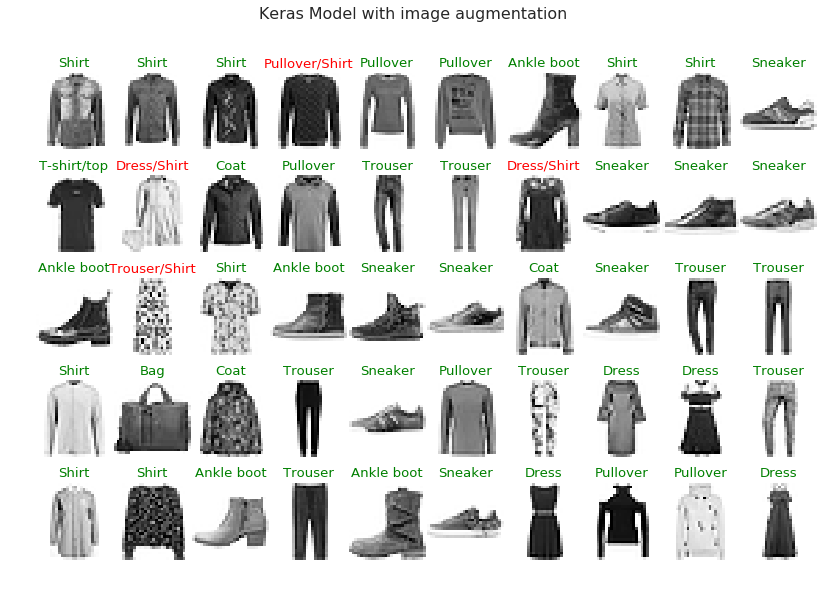

In [0]:
do_predictions(model_name_aug, X_test, y_test, test_images, test_labels, 
               plot_title=plot_title_aug)

## Summary
* In this workbook we created a CNN with Keras to classify the Fashion-MNIST dataset.
* Since the images are more complex than our digits images, the model was more complex than the MNIST Digits model
* The base model overfit the training data significantly (~8%), but we were able to reduce this by implementing regularization techniques like L2 regularization and dropout regularization
* Finally, we implemented Image Augmentation, where we observed that our cross-validation curves tracked the training curves for most of the iterations. We did not see significant degredation of performance viz-a-viz the regularized versions without Image Augmentation.
# <center> - - END - - </center>